Выполнила: Анастасия Плавина

## Урок 4. Uplift-моделирование

### 1. Цель
Предсказание конверсии клиента в рамках маркетинговой промоакции для максимизации профита маркетинговой кампании и сокращении затрат на ее организацию.

### 2. Описание данных

Данные о клиентах объемом 6400.

- recency - количество месяцев с последней покупки
- history - количество покупок за все время
- used_discount - индикатор использования скидки
- used_bogo - индикатор использования акции "два по цене одного"
- zip_code - характеристика местоположения Suburban/Urban/Rural 
- is_referral - индикатор того, что клиент привлечен через реферальную программу
- channel - канал взаимодейтсвия Phone/Web/Multichannel
- offer - оказанное воздействие Discount/But One Get One/No Offer
- conversion - конверсия (была ли совершена покупка)

### 3. Загрузка данных

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_by_percentile
from sklift.models import SoloModel


# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

sns.set_style('darkgrid')

In [45]:
df = pd.read_csv('data.csv')
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [46]:
# переименовываем колонки
df.rename(columns={'offer': 'treatment', 'conversion': 'target'}, inplace=True)

# зприводим treatment к бинарному виду
df.loc[df['treatment'].isin(['Discount','Buy One Get One']), 'treatment'] = 1 
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0 
df['treatment'] = df['treatment'].astype(int)
df['treatment'].unique()

array([1, 0])

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


### 4. Обзор целевой переменной

Соотношение целевой переменной:
0 (нет конверсии) - 85%
1 (конверсия) - 15%


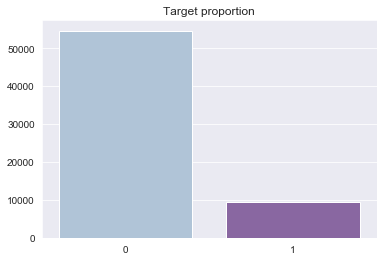

In [48]:
target = 'target'
features = df.columns.drop(target).tolist()

counts = df[target].value_counts()

print('Соотношение целевой переменной:')
print(f'0 (нет конверсии) - {counts[0]/df.shape[0]*100:.0f}%')
print(f'1 (конверсия) - {counts[1]/df.shape[0]*100:.0f}%')
  
plt.title('Target proportion')
sns.barplot(counts.index, counts.values, palette='BuPu')
plt.show()

### 5. Обзор признаков

In [49]:
df.dtypes

recency            int64
history          float64
used_discount      int64
used_bogo          int64
zip_code          object
is_referral        int64
channel           object
treatment          int64
target             int64
dtype: object

In [50]:
cat_feature_names = ['channel', 'zip_code', 'used_discount', 'used_bogo', 'is_referral', 'treatment']
num_feature_names = ['recency', 'history']

In [51]:
# нет пропусков
df.isna().sum()

recency          0
history          0
used_discount    0
used_bogo        0
zip_code         0
is_referral      0
channel          0
treatment        0
target           0
dtype: int64

#### 5.1 Категориальные признаки

channel
Web - 44%
Phone - 44%
Multichannel - 12%

-------------------------
zip_code
Surburban - 45%
Urban - 40%
Rural - 15%

-------------------------
used_discount
1 - 55%
0 - 45%

-------------------------
used_bogo
1 - 55%
0 - 45%

-------------------------
is_referral
1 - 50%
0 - 50%

-------------------------
treatment
1 - 67%
0 - 33%

-------------------------


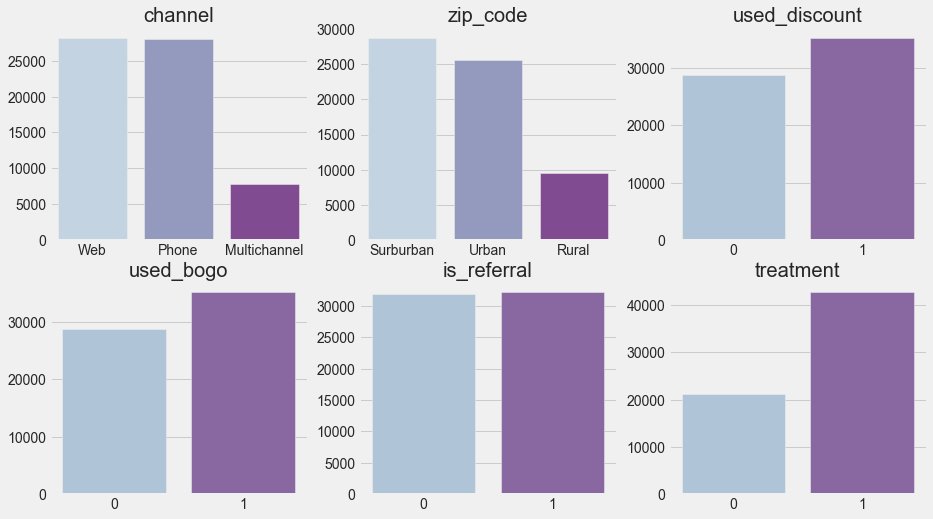

In [150]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(14, 8))

for i, ax in enumerate(axes.flat):
    counts = df[cat_feature_names[i]].value_counts()
    print(str(cat_feature_names[i]))
    for name in counts.index:  
        print(f'{name} - {counts[name]/df.shape[0]*100:.0f}%')
    sns.barplot(counts.index, counts.values, ax=ax, palette='BuPu')
    ax.set_title(cat_feature_names[i])
    print('\n-------------------------')

plt.show()

#### 5.2. Количественные признаки

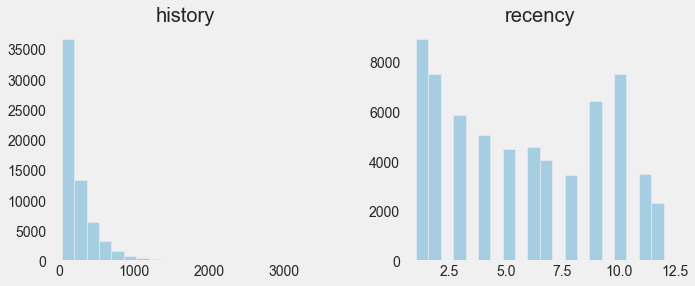

In [151]:
df[num_feature_names].hist(figsize=(10,4), bins=20, grid=False)
plt.show()

### 6. Разбиение на тренировочную и тестовую выборки

In [54]:
df_test = df[df['treatment'] == 0][:5000]

train_index = list(set(df.index) - set(df_test.index))
df_train = df.iloc[train_index]

In [114]:
X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train[target], shuffle=True, 
                                                    test_size=0.30, random_state=21)
treat_train = X_train['treatment']
treat_val = X_test['treatment']


models_results = {}
models_results['approach'] = []
models_results['uplift@10%'] = []
models_results['uplift@20%'] = []

X_train

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment
27384,3,378.10,1,0,Surburban,0,Web,0
274,6,92.32,0,1,Urban,0,Phone,1
10913,6,29.99,1,0,Rural,1,Web,1
12369,3,157.72,1,0,Urban,0,Web,1
16329,2,242.13,1,0,Rural,0,Phone,1
...,...,...,...,...,...,...,...,...
21432,9,29.99,0,1,Urban,1,Web,0
13465,10,56.24,0,1,Surburban,0,Phone,1
8911,3,147.13,0,1,Surburban,0,Phone,1
7963,3,53.88,1,0,Surburban,0,Phone,1


### 7. Feature engineering

In [128]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class NumericPower(BaseEstimator, TransformerMixin):
    def __init__(self, key, p):
        self.key = key
        self.columns = []
        self.p = p+1

    def fit(self, X, y=None):
        #self.columns = [self.key+'^'+str(col) for col in range(2,self.p)]
        return self

    def transform(self, X):
        Xp = X.copy()
       
        for i in range(2,self.p):
            self.columns += [self.key+'^'+str(i)]
            Xp[self.key+'^'+str(i)] = Xp[self.key].values ** i
        
        return Xp.loc[:,self.columns]
    
class Numericlog(BaseEstimator, TransformerMixin):
    def __init__(self, key, p):
        self.key = key
        self.columns = []
        self.p = p+1

    def fit(self, X, y=None):
        #self.columns = [self.key+'log_'+str(col) for col in range(2,self.p)]
        return self

    def transform(self, X):
        Xp = X.copy()
       
        for i in range(2,self.p):
            self.columns += [self.key+'log_'+str(i)]
            Xp[self.key+'log_'+str(i)] = np.log(np.abs(Xp[self.key].values)+0.01)/np.log(i)

        result = Xp.loc[:,self.columns]
        return result

class NumericMix(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []
        

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        Xp = X[self.key].copy()
        #print(Xp)
        s = self.key
        for col1 in s[:-1]:
            for col2 in s[1:]:   
                Xp[col1+'/'+col2] = Xp.loc[:,col1].values/(np.abs(Xp.loc[:,col2].values)+0.01)

                Xp[col1+'*'+col2] = Xp.loc[:,col1].values*Xp.loc[:,col2].values
                self.columns += [col1+'/'+col2, col1+'*'+col2]
        return Xp.loc[:,self.columns]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
      

final_transformers = []
# преобразование кол. признаков
for col_n in num_feature_names:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=col_n)),
                ('scaler1', Numericlog(key=col_n, p=3)),
                ('scaler2', StandardScaler())
            ])
    final_transformers.append((col_n, cont_transformer))

    
# микс всех кол. признаков
# all_mix = Pipeline([('scaler', NumericMix(key=num_feature_names))])
# final_transformers.append((num_feature_names, all_mix))
    
    
# преобразование кат. признаков
for col_cat in ['channel', 'zip_code']:
    col_transformer1 = Pipeline([
                ('selector', FeatureSelector(col_cat)),
                ('scaler', OHEEncoder(key=col_cat)),

            ])
    final_transformers.append((col_cat, col_transformer1))
    
    
feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit(X_train)
feature_processing.fit_transform(X_test)

array([[ 1.12779975,  1.12779975,  1.12779975, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.00913057,  1.00913057,  1.00913057, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.37333282,  0.37333282,  0.37333282, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.13095045, -0.13095045, -0.13095045, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.1465253 ,  0.1465253 ,  0.1465253 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.1465253 ,  0.1465253 ,  0.1465253 , ...,  0.        ,
         1.        ,  0.        ]])

### 8. Обучение модели

In [129]:
model = Pipeline([
    ('features', feats),
    ('model', SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))),
    ])


In [130]:
model.predict(X_test) # тут не работает 

ValueError: operands could not be broadcast together with shapes (17700,6) (4,) (17700,6) 

#### 8.1. Одиночная модель

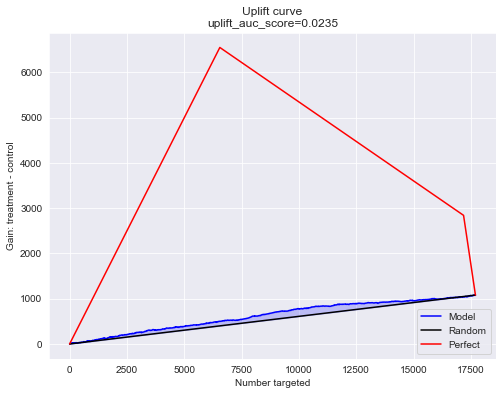

In [18]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': ['zip_code', 'channel']})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

from sklift.viz import plot_uplift_curve

plot_uplift_curve(y_true=y_test, uplift=uplift_sm, treatment=treat_val)

#### 8.2. Две модели

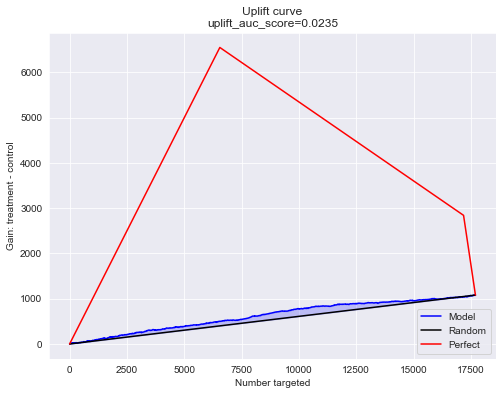

In [19]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': ['zip_code', 'channel']}, 
    estimator_ctrl_fit_params={'cat_features': ['zip_code', 'channel']}
)

uplift_tm = tm.predict(X_test)

tm_score10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score10)
models_results['uplift@20%'].append(tm_score20)

plot_uplift_curve(y_true=y_test, uplift=uplift_sm, treatment=treat_val)

#### 8.3. Трансформация классов

In [20]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': ['zip_code', 'channel']})

uplift_ct = ct.predict(X_test)

ct_score10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)


models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score10)
models_results['uplift@20%'].append(ct_score20)

<ipython-input-20-1611f0fbf119>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': ['zip_code', 'channel']})


In [21]:
df_results = pd.DataFrame(models_results)
df_results

,approach,uplift@10%,uplift@20%
0,SoloModel,0.086602,0.086038
1,TwoModels,0.105637,0.086123
2,ClassTransformation,0.250407,0.219304


### Строим UpliftTreeClassifier

In [147]:
X_train_tree = pd.concat([X_train.drop('zip_code', 1), pd.get_dummies(X_train['zip_code'], prefix='zip_code')], 1)
X_train_tree = pd.concat([X_train_tree.drop('channel', 1), pd.get_dummies(X_train_tree['channel'], prefix='channel')], 1)
X_train_tree

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
27384,3,378.10,1,0,0,0,0,1,0,0,0,1
274,6,92.32,0,1,0,1,0,0,1,0,1,0
10913,6,29.99,1,0,1,1,1,0,0,0,0,1
12369,3,157.72,1,0,0,1,0,0,1,0,0,1
16329,2,242.13,1,0,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
21432,9,29.99,0,1,1,0,0,0,1,0,0,1
13465,10,56.24,0,1,0,1,0,1,0,0,1,0
8911,3,147.13,0,1,0,1,0,1,0,0,1,0
7963,3,53.88,1,0,0,1,0,1,0,0,1,0


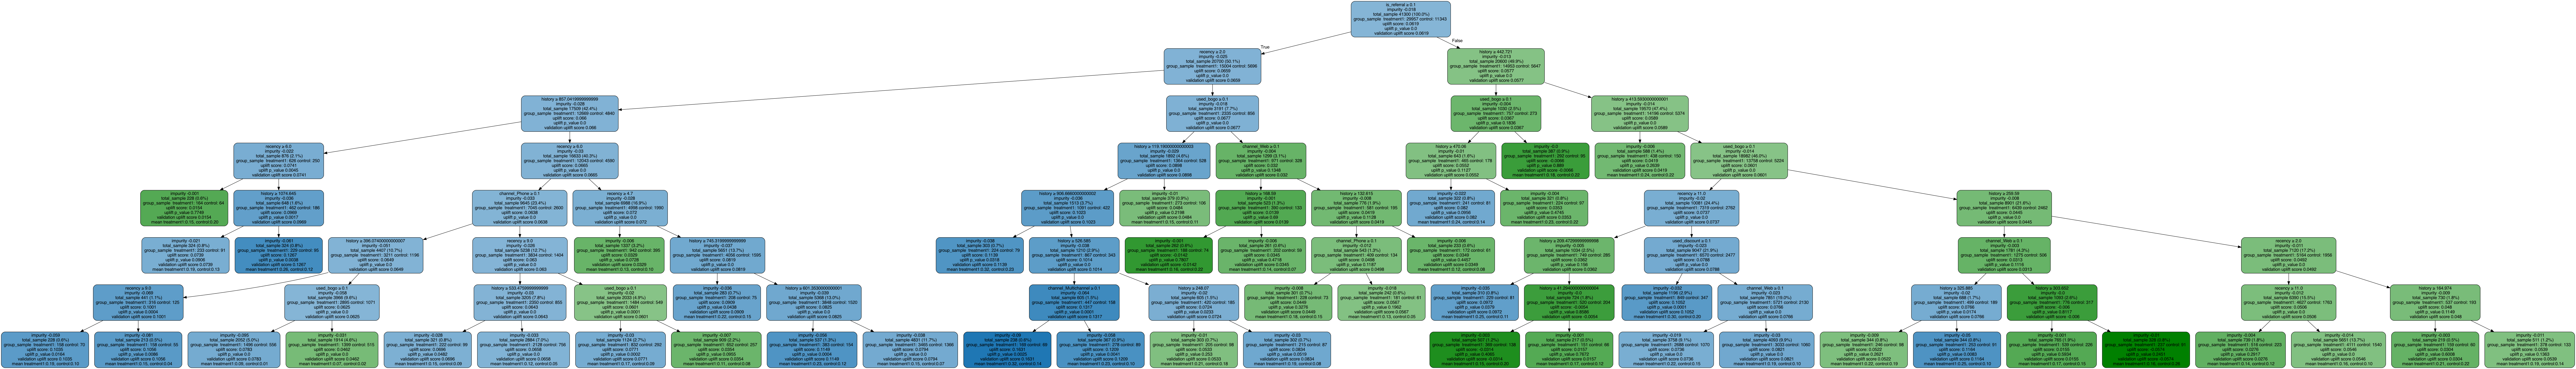

In [149]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_trainrain.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())



По дереву видим, что хорошее значение аплифт (0.16) получаем на пользователях, которые совершали последнюю покупку покупки не раньше, чем 2 месяца назад, участвовали в акции 2 по цене одного, совершили в целом больше 119 покупок.